# MORE EFFICIENT PORTFOLIO ALLOCATION WITH QUASI-MONTE CARLO METHODS USING QMCPY
Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

modification date: 08/12/2024

In [3]:

import qmcpy as qp
from qmcpy import *
import pandas as pd
import numpy as np

#!pip install yfinance
import yfinance as yf

from datetime import date
import seaborn as sn

import matplotlib.pyplot as plt
import time

from scipy.optimize import minimize
import timeit

*Portfolio allocation* is a strategic process that aims to balance risk and return by distributing funds among diverse assets with varying risks and returns [5]. The goal is to create a diversified portfolio that can mitigate risk and  enhance returns over time, while  reducing the impact of market changes on individual assets. In this study for portfolio allocation, utilizing the open-source QMCPy library[2,3], we apply quasi-Monte Carlo methods in the distribution of funds among individual stocks in a portfolio.

In [4]:
start_date = '2012-01-01'
#today = date.today()
end_date = '2023-08-04'

In [5]:
def download_data(tickers,description):
    col_names = ['Ticker', 'Company', 'Date', 'Adj Close Price', 'Volume']
    df = pd.DataFrame(columns=col_names)
    for i,ticker in enumerate(tickers):
        company = description[i]
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Ticker'] = ticker
        data['Company'] = company
        data.reset_index(inplace=True)
        data = data[['Ticker', 'Company', 'Date', 'Adj Close', 'Volume']]
        data.columns = col_names
        data.head()
        df = pd.concat([df, data], ignore_index=True)
    return df

In [6]:
def get_log_ret(df):
    stocks = df.pivot(index='Date', columns='Ticker', values='Adj Close Price')
    log_ret = np.log(stocks/stocks.shift(1))

    return log_ret

# generating weights with lattice points

In [7]:
def gen_weights_lattice(n,num_ports):

    l = qp.Lattice(dimension = n, seed = 42)
    weights = l.gen_samples(num_ports) # using lattice points instead of iid
    weights /= np.sum(weights, axis=1)[:, np.newaxis]
    return weights

## generating weights with i.i.d. points

In [8]:
def gen_weights_iid(n,num_ports):
    np.random.seed(42)
    # Generate all weights randomly from continuous uniform distribution in [0,1)
    weights = np.random.random((num_ports, n))
    weights /= np.sum(weights, axis=1)[:, np.newaxis]
    return weights

## computing Sharpe Ratio
Sharpe Ratio is given by: $\frac{R}{V}$, where $R = \sum_{i=1}^{d} R_iw_i$ stands for the excess expected return of a portfolio and $V = \sqrt{\sum_{i=1}^{d} \sum_{j=1}^{d} \sigma_{ij} w_i w_j}$ represents  its expected volatility with $d$ number of assets in a portfolio, weights $w_i$'s, and covariance of assets $i$ and $j$ $\sigma_{ij}$

In [9]:
def sharpe(weights,log_ret):
    np.random.seed(42)
    # Expected return
    ret_arr = np.sum((log_ret.mean().values * weights * 252), axis=1)

    # Expected volatility
    vol_arr = np.sqrt((weights @ (log_ret.cov().values * 252)) @ weights.T).diagonal()

    # Sharpe Ratio
    sharpe_arr = ret_arr/vol_arr

    # Rounding values
    sharpe_arr = np.round(sharpe_arr, decimals=3)
    ret_arr = np.round(ret_arr, decimals=3)
    vol_arr = np.round(vol_arr, decimals=3)
    all_weights = np.round(weights, decimals=3)

    # max
    max_sharpe_ratio = sharpe_arr.max()
    location_in_array = sharpe_arr.argmax()
    max_sr_ret = ret_arr[location_in_array]
    max_sr_vol = vol_arr[location_in_array]
    max_sharpe_ratio = np.round(max_sr_ret/max_sr_vol,decimals=3)

    # mid
    medium_risk_tolerance = np.quantile(vol_arr, 2/3, axis=0)
    medium_risk_idx = np.where(vol_arr<medium_risk_tolerance)
    medium_risk_max_sharpe_ratio = sharpe_arr[medium_risk_idx].max()
    location_in_array = sharpe_arr[medium_risk_idx].argmax()
    medium_risk_sr_ret = ret_arr[medium_risk_idx][location_in_array]
    medium_risk_sr_vol = vol_arr[medium_risk_idx][location_in_array]
    medium_risk_max_sharpe_ratio = np.round(medium_risk_sr_ret/medium_risk_sr_vol,decimals=3)

    # low
    low_risk_tolerance = np.quantile(vol_arr, 1/3, axis=0)
    low_risk_idx = np.where(vol_arr<low_risk_tolerance)
    low_risk_max_sharpe_ratio = sharpe_arr[low_risk_idx].max()
    location_in_array = sharpe_arr[low_risk_idx].argmax()
    low_risk_sr_ret = ret_arr[low_risk_idx][location_in_array]
    low_risk_sr_vol = vol_arr[low_risk_idx][location_in_array]
    low_risk_max_sharpe_ratio = np.round(low_risk_sr_ret/low_risk_sr_vol,decimals =3)

    return {"number of tickers":len(weights[0]),"number of portfolios":len(weights),"low": all_weights[low_risk_idx][location_in_array].tolist(), "medium": all_weights[medium_risk_idx][location_in_array].tolist(), "high": all_weights[location_in_array].tolist(),
            "low risk Sharpe":low_risk_max_sharpe_ratio,"medium risk Sharpe":medium_risk_max_sharpe_ratio,"high risk Sharpe":max_sharpe_ratio}


# Testing Sharpe ratios
We now test the two approaches by computing Sharpe ratios at different risk levels employing the weights obtained from each method.

As we can see from the tables below, the values of Sharpe ratio do not significantly change based on the number of portfolios. We might want to look furher into this: will results change more significantly if we triple the number of portfolios for the tickers we worked with, or what happens if we use much greater number of tickers to begin with.


## Testing Sharpe ratios with lattice weights for four tickers
We start with obtaining the data for four tickers and generate three different arrays of weights for the tickers using lattice points. We then compute the Sharpe ratios for three different levels of risk strategies using the log returns and the generated weights. 

In [43]:
tickers = ["AAPL", "AMZN", "CSCO","IBM"]
description = ["Apple", "Amazon", "CISCO", "IBM"]

df = download_data(tickers,description)

# log return for the 4 stocks
lr = get_log_ret(df)

w1_qmc = gen_weights_lattice(4,2**13)
sr1_qmc = sharpe(w1_qmc,lr)

w2_qmc = gen_weights_lattice(4,2**14)
sr2_qmc = sharpe(w2_qmc,lr)

w3_qmc = gen_weights_lattice(4,2**15)
sr3_qmc = sharpe(w3_qmc,lr)

data_qmc = {
    'number of tickers': [len(w1_qmc[0]), len(w1_qmc[0]), len(w1_qmc[0])],
    'number of portfolios': [len(w1_qmc),len(w2_qmc),len(w3_qmc)],
    'low risk Sharpe': [sr1_qmc['low risk Sharpe'],sr2_qmc['low risk Sharpe'],sr3_qmc['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc['medium risk Sharpe'],sr2_qmc['medium risk Sharpe'],sr3_qmc['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc['high risk Sharpe'],sr2_qmc['high risk Sharpe'],sr3_qmc['high risk Sharpe']]

}
df_qmc = pd.DataFrame.from_dict(data_qmc, orient='columns')
df_qmc = df_qmc.pivot(index='number of portfolios', columns='number of tickers')
df_qmc

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,4,4,4
number of portfolios,,,
8192,0.737,0.815,0.892
16384,0.737,0.815,0.892
32768,0.737,0.815,0.892


## Testing Sharpe ratios with iid weights for four tickers
We download the data for the same tickers and repeat the process using iid points to generate the weights.

In [44]:
np.random.seed(42)

# generate weights with iid points


w1_mc = gen_weights_iid(4,2**13)
sr1_mc = sharpe(w1_mc,lr)

w2_mc = gen_weights_iid(4,2**14)
sr2_mc = sharpe(w2_mc,lr)

w3_mc = gen_weights_iid(4,2**15)
sr3_mc = sharpe(w3_mc,lr)

data_mc = {
    'number of tickers': [len(w1_mc[0]), len(w1_mc[0]), len(w1_mc[0])],
    'number of portfolios': [len(w1_mc),len(w2_qmc),len(w3_mc)],
    'low risk Sharpe': [sr1_mc['low risk Sharpe'],sr2_mc['low risk Sharpe'],sr3_mc['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc['medium risk Sharpe'],sr2_mc['medium risk Sharpe'],sr3_mc['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc['high risk Sharpe'],sr2_mc['high risk Sharpe'],sr3_mc['high risk Sharpe']]

}
df_mc = pd.DataFrame.from_dict(data_mc, orient='columns')
df_mc = df_mc.pivot(index='number of portfolios', columns='number of tickers')
df_mc

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,4,4,4
number of portfolios,,,
8192,0.737,0.815,0.892
16384,0.737,0.815,0.892
32768,0.737,0.815,0.892


## Testing Sharpe ratios with lattice weights for ten tickers

Now, we dowload the data for 10 tickers and generate new weights using lattice points and compute the Sharpe ratios. We use the same number of portfolios (sampling points) as in the case with four tickers.

In [45]:


tickers1 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA"]
description1 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna"]
df1 = download_data(tickers1,description1)

lr1 = get_log_ret(df1)

w1_qmc10 = gen_weights_lattice(10,2**13)
sr1_qmc10 = sharpe(w1_qmc10,lr1)

w2_qmc10 = gen_weights_lattice(10,2**14)
sr2_qmc10 = sharpe(w2_qmc10,lr1)

w3_qmc10 = gen_weights_lattice(10,2**15)
sr3_qmc10 = sharpe(w3_qmc10,lr1)

data_qmc10 = {
    'number of tickers': [len(w1_qmc10[0]), len(w1_qmc10[0]), len(w1_qmc10[0])],
    'number of portfolios': [len(w1_qmc10),len(w2_qmc10),len(w3_qmc10)],
    'low risk Sharpe': [sr1_qmc10['low risk Sharpe'],sr2_qmc10['low risk Sharpe'],sr3_qmc10['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc10['medium risk Sharpe'],sr2_qmc10['medium risk Sharpe'],sr3_qmc10['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc10['high risk Sharpe'],sr2_qmc10['high risk Sharpe'],sr3_qmc10['high risk Sharpe']]

}
df_qmc10 = pd.DataFrame.from_dict(data_qmc10, orient='columns')
df_qmc10 = df_qmc10.pivot(index='number of portfolios', columns='number of tickers')
df_qmc10

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,10,10,10
number of portfolios,,,
8192,0.987,0.992,1.022
16384,0.987,0.996,1.022
32768,0.992,0.996,1.022


## Testing Sharpe ratios with iid weights for ten tickers
We repeat the above procedure using iid points 

In [46]:
np.random.seed(42)

w1_mc10 = gen_weights_iid(10,2**13)
sr1_mc10 = sharpe(w1_mc10,lr1)

w2_mc10 = gen_weights_iid(10,2**14)
sr2_mc10= sharpe(w2_mc10,lr1)

w3_mc10 = gen_weights_iid(10,2**15)
sr3_mc10 = sharpe(w3_mc10,lr1)

data_mc10 = {
    'number of tickers': [len(w1_mc10[0]), len(w1_mc10[0]), len(w1_mc10[0])],
    'number of portfolios': [len(w1_mc10),len(w2_qmc10),len(w3_mc10)],
    'low risk Sharpe': [sr1_mc10['low risk Sharpe'],sr2_mc10['low risk Sharpe'],sr3_mc10['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc10['medium risk Sharpe'],sr2_mc10['medium risk Sharpe'],sr3_mc10['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc10['high risk Sharpe'],sr2_mc10['high risk Sharpe'],sr3_mc10['high risk Sharpe']]

}
df_mc10 = pd.DataFrame.from_dict(data_mc10, orient='columns')
df_mc10 = df_mc10.pivot(index='number of portfolios', columns='number of tickers')
df_mc10

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,10,10,10
number of portfolios,,,
8192,0.984,0.996,0.996
16384,0.984,0.996,0.996
32768,0.996,0.996,0.996


## Testing Sharpe ratios with lattice weights for twenty tickers


In [14]:


tickers2 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA","^IXIC", "T","GE","FMC","AMC","JPM","DIS","WBA","GOOGL","BA"]
description2 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna","NASDAQ","AT&T","General Electric","FMC","AMC","JPMorgan","Disney","WBA","Google","Boeing"]

df2 = download_data(tickers2,description2)

lr2 = get_log_ret(df2)

w1_qmc20 = gen_weights_lattice(20,2**13)
sr1_qmc20 = sharpe(w1_qmc20,lr2)

w2_qmc20 = gen_weights_lattice(20,2**14)
sr2_qmc20 = sharpe(w2_qmc20,lr2)

w3_qmc20 = gen_weights_lattice(20,2**15)
sr3_qmc20 = sharpe(w3_qmc20,lr2)

data_qmc20 = {
    'number of tickers': [len(w1_qmc20[0]), len(w1_qmc20[0]), len(w1_qmc20[0])],
    'number of portfolios': [len(w1_qmc20),len(w2_qmc20),len(w3_qmc20)],
    'low risk Sharpe': [sr1_qmc20['low risk Sharpe'],sr2_qmc20['low risk Sharpe'],sr3_qmc20['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc20['medium risk Sharpe'],sr2_qmc20['medium risk Sharpe'],sr3_qmc20['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc20['high risk Sharpe'],sr2_qmc20['high risk Sharpe'],sr3_qmc20['high risk Sharpe']]

}
df_qmc20 = pd.DataFrame.from_dict(data_qmc20, orient='columns')
df_qmc20 = df_qmc20.pivot(index='number of portfolios', columns='number of tickers')
df_qmc20

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 for lattice points:




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,20,20,20
number of portfolios,,,
6000,0.856,0.918,0.915
10000,0.856,0.918,0.915
15000,0.869,0.918,0.915


In [141]:
np.random.seed(42)

w1_mc20 = gen_weights_iid(20,2**13)
sr1_mc20 = sharpe(w1_mc20,lr2)

w2_mc20 = gen_weights_iid(20,2**14)
sr2_mc20= sharpe(w2_mc20,lr2)

w3_mc20 = gen_weights_iid(20,2**15)
sr3_mc20 = sharpe(w3_mc20,lr2)

data_mc20 = {
    'number of tickers': [len(w1_mc20[0]), len(w1_mc20[0]), len(w1_mc20[0])],
    'number of portfolios': [len(w1_mc20),len(w2_mc20),len(w3_mc20)],
    'low risk Sharpe': [sr1_mc20['low risk Sharpe'],sr2_mc20['low risk Sharpe'],sr3_mc20['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc20['medium risk Sharpe'],sr2_mc20['medium risk Sharpe'],sr3_mc20['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc20['high risk Sharpe'],sr2_mc20['high risk Sharpe'],sr3_mc20['high risk Sharpe']]

}
df_mc20 = pd.DataFrame.from_dict(data_mc20, orient='columns')
df_mc20 = df_mc20.pivot(index='number of portfolios', columns='number of tickers')
df_mc20

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,20,20,20
number of portfolios,,,
8192,0.873,0.873,0.873
16384,0.873,0.885,0.885
32768,0.880,0.885,0.885


# Runtime comparison
We now proceed to compare the performance of the two methods by measuing their runtime. We consider both real (clock) time as well as CPU time.

## Real time
We record the runtime (in second) for 6 tickers-portfolios pairs to see which method performs better as the dimension increases

### Measuring the weights generation using lattice points
We generate the weights using lattice points, imcreasing the number of tickers and portfolios for each subsequent pair

In [134]:
params = [
    (4, 2**14),     
    (10, 2**15),   
    (20, 2**16),    
    (100, 2**17),   
    (500, 2**18),   
    (1000, 2**19)   
]

lattice_results = []

for tickers, portfolios in params:
    start_time = time.time()
    lattice_weights = gen_weights_lattice(tickers, portfolios)
    end_time = time.time()
    time_taken = end_time - start_time
    
    
    lattice_results.append({
        'Tickers': tickers,
        'Portfolios': portfolios,
        'Lattice Runtime (s)': time_taken
    })


df_real_time = pd.DataFrame(lattice_results)

### Measuring the weights generation using iid points
Using the same number of tickers and portfolios as above in each pair, we measure the runtime for weights generation using iid points

In [135]:
params = [
    (4, 2**14),     
    (10, 2**15),   
    (20, 2**16),    
    (100, 2**17),   
    (500, 2**18),   
    (1000, 2**19)   
]

iid_results = []

for tickers, portfolios in params:
    start_time = time.time()
    iid_weights = gen_weights_iid(tickers, portfolios)
    end_time = time.time()
    time_taken = end_time - start_time
    
    iid_results.append(time_taken)


df_real_time['IID Runtime (s)'] = iid_results

### IID vs Lattice real time 
The table below shows the runtime (s) for both methods using the same parameters

In [136]:
df_real_time

,Tickers,Portfolios,Lattice Runtime (s),IID Runtime (s)
0,4,16384,0.074601,0.017481
1,10,32768,0.011760,0.001339
2,20,65536,0.035503,0.005084
3,100,131072,0.303226,0.048500
4,500,262144,3.045826,0.465904
5,1000,524288,18.156796,1.867177


# Visualizing runtime

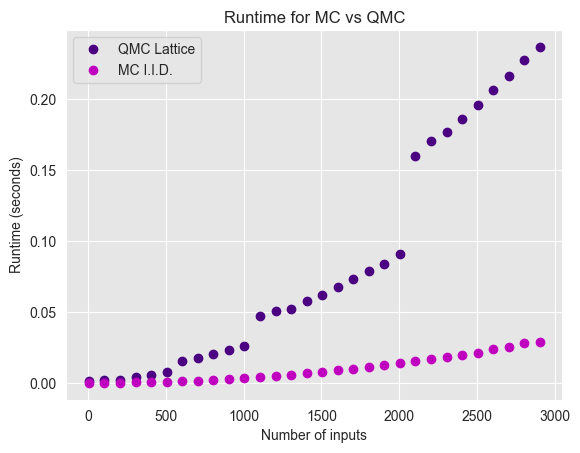

In [21]:
ns = range(5, 3000, 100)
ts = [timeit.timeit('gen_weights_lattice({},{})'.format(n,n),
                    globals=globals(),
                    number=1)
         for n in ns]
plt.plot(ns, ts, color='indigo',marker='o',linestyle='none')


ns1 = range(5, 3000,100)
ts1 = [timeit.timeit('gen_weights_iid({},{})'.format(n,n),
                    globals=globals(),
                    number=1)
         for n in ns1]
plt.plot(ns1, ts1, 'om')

plt.title("Runtime for MC vs QMC")
plt.legend(['QMC Lattice','MC I.I.D.'])
plt.xlabel("Number of inputs")
plt.ylabel("Runtime (seconds)")

plt.show()

## CPU time

### Lattice CPU

In [137]:

lattice_results_cpu = []

for tickers, portfolios in params:
    start_time = time.process_time()
    lattice_weights = gen_weights_lattice(tickers, portfolios)
    end_time = time.process_time()
    time_taken = end_time - start_time
    
    lattice_results_cpu.append({
        'Tickers': tickers,
        'Portfolios': portfolios,
        'Lattice Time (s)': time_taken
    })

df_cpu_time =  pd.DataFrame(lattice_results_cpu)

### IID CPU

In [138]:
iid_results_cpu = []

for tickers, portfolios in params:
    start_time = time.process_time()
    iid_weights = gen_weights_iid(tickers, portfolios)
    end_time = time.process_time()
    time_taken = end_time - start_time
    
    iid_results_cpu.append(time_taken)


df_cpu_time['IID Time (s)'] = iid_results_cpu

In [139]:
df_cpu_time

,Tickers,Portfolios,Lattice Time (s),IID Time (s)
0,4,16384,0.035664,0.017815
1,10,32768,0.018835,0.002206
2,20,65536,0.054169,0.006583
3,100,131072,0.498238,0.051980
4,500,262144,5.056340,0.474545
5,1000,524288,23.587480,2.749437


## Backtesting

*Backtesting* - a method used to retrospectively evaluate the effectiveness of a strategy by simulating its performance using historical data

In [97]:
aapl = df[df['Ticker']== 'AAPL'].reset_index()
amzn = df[df['Ticker']== 'AMZN'].reset_index()
csco = df[df['Ticker']== 'CSCO'].reset_index()
ibm = df[df['Ticker']== 'IBM'].reset_index()

In [98]:
aapl = aapl.set_index('Date')
amzn = amzn.set_index('Date')
csco = csco.set_index('Date')
ibm = ibm.set_index('Date')


In [99]:
# normalize return
for stock_df in (aapl,  amzn, csco, ibm):
    stock_df['Norm Return'] = stock_df['Adj Close Price'] / stock_df.iloc[0]['Adj Close Price']

In [100]:
principal = 10000 # starting investment value
num_ports = 10000
risk_level = "high"
qmc_weights = sr2_qmc
mc_weights =  sr2_mc

### portfolio performance for QMC

In [101]:
# for max sharpe (qmcpy)
for stock_df, allocation in zip((aapl, amzn, csco, ibm), qmc_weights[risk_level]):
    stock_df['Allocation'] = stock_df['Norm Return'] * allocation
    stock_df['Position'] = stock_df['Allocation']*principal

In [102]:
all_pos = [aapl['Position'], amzn['Position'], csco['Position'], ibm['Position']]
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = ['AAPL Pos','AMZN Pos', 'CISCO Pos','IBM Pos']
portf_val['Total Pos'] = portf_val.sum(axis=1)
portf_val

,AAPL Pos,AMZN Pos,CISCO Pos,IBM Pos,Total Pos
Date,,,,,
2012-01-03,3440.000000,1810.000000,2450.000000,2300.000000,10000.000000
2012-01-04,3458.487013,1794.632700,2497.342964,2290.617151,10041.079828
2012-01-05,3496.882994,1795.643727,2488.137536,2279.753430,10060.417687
2012-01-06,3533.438782,1846.193914,2478.932108,2253.580496,10112.145300
2012-01-09,3527.834712,1805.248386,2494.712054,2241.852055,10069.647206
...,...,...,...,...,...
2023-07-28,53966.123635,26732.962496,9728.140416,2856.064209,93283.290756
2023-07-31,54136.986625,27030.194760,9718.802082,2870.598799,93756.582266
2023-08-01,53905.504241,26627.817242,9834.590807,2853.675644,93221.587934


### portfolio performance for iid

In [103]:
# max sharpe (iid)
for stock_df_iid, allocation in zip((aapl, amzn, csco, ibm), mc_weights[risk_level]):
    stock_df_iid['Allocation'] = stock_df_iid['Norm Return'] * allocation
    stock_df_iid['Position'] = stock_df_iid['Allocation']*principal

In [104]:
all_pos_iid = [aapl['Position'], amzn['Position'], csco['Position'], ibm['Position']]
portf_val_iid = pd.concat(all_pos_iid, axis=1)
portf_val_iid.columns = ['AAPL Pos','AMZN Pos','CISCO Pos','IBM Pos']
portf_val_iid['Total Pos'] = portf_val_iid.sum(axis=1)
portf_val_iid

,AAPL Pos,AMZN Pos,CISCO Pos,IBM Pos,Total Pos
Date,,,,,
2012-01-03,1360.000000,2400.000000,4890.000000,1350.000000,10000.000000
2012-01-04,1367.308819,2379.623469,4984.492692,1344.492675,10075.917655
2012-01-05,1382.488626,2380.964058,4966.119408,1338.116144,10067.688235
2012-01-06,1396.940914,2447.991930,4947.746125,1322.753770,10115.432739
2012-01-09,1394.725351,2393.699517,4979.241610,1315.869684,10083.536162
...,...,...,...,...,...
2023-07-28,21335.444228,35447.022094,19416.574137,1676.385514,77875.425973
2023-07-31,21402.994712,35841.142223,19397.935584,1684.916686,78326.989206
2023-08-01,21311.478421,35307.602973,19629.040427,1674.983530,77923.105351


In [105]:
qmc_n_mc = [portf_val['Total Pos'],portf_val_iid['Total Pos']]
qmc_vs_mc = pd.concat(qmc_n_mc,axis=1)
qmc_vs_mc.columns = ['QMC Total Pos','MC Total Pos']
qmc_vs_mc

,QMC Total Pos,MC Total Pos
Date,,
2012-01-03,10000.000000,10000.000000
2012-01-04,10041.079828,10075.917655
2012-01-05,10060.417687,10067.688235
2012-01-06,10112.145300,10115.432739
2012-01-09,10069.647206,10083.536162
...,...,...
2023-07-28,93283.290756,77875.425973
2023-07-31,93756.582266,78326.989206
2023-08-01,93221.587934,77923.105351


<AxesSubplot:title={'center':'Portfolio Value for Max Sharpe Ratio'}, xlabel='Date'>

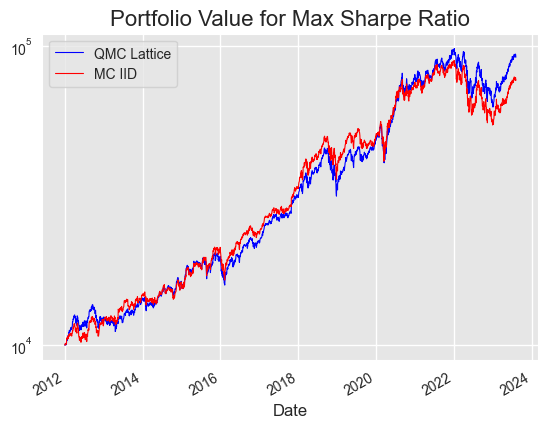

In [108]:
sn.set_style("darkgrid", {"axes.facecolor": ".9"})
qmc_vs_mc.columns = ['QMC Lattice','MC IID']
qmc_vs_mc.plot(title='Portfolio Value for Max Sharpe Ratio', logy=True,linewidth=0.8,color=['blue','red'])

In [109]:
qmc_vs_mc['(QMC - MC)/principal'] = (qmc_vs_mc["QMC Lattice"]-qmc_vs_mc["MC IID"])/principal

<AxesSubplot:title={'center':'Daily difference of QMC and MC portfolio values per invested dollar on 2012-01-01 with 10000 sampling points'}, xlabel='Date'>

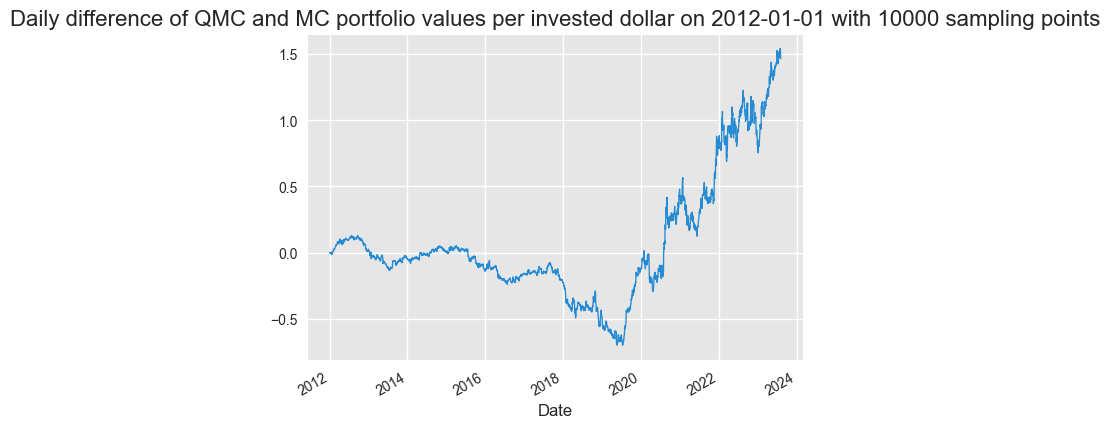

In [110]:
qmc_vs_mc['(QMC - MC)/principal'].plot(title=f"Daily difference of QMC and MC portfolio values per invested dollar on {start_date} with {num_ports} sampling points",linewidth=0.95)

In [37]:
# to do:

# add .py file to workouts folder

# add text to markdown cells

# improve visuals 

